# Predcition of Hospital Admission Related to Infections

In this notebook, we develop a Cox proportional hazard regression model to predict the risk of hospital admission for common infections including urinary tract infection (UTI), upper respiratory tract infection (URTI), lower respiratory tract infection (LRTI), sinusitis, otitis media or middle ear infection (ot media), and ear infection or otitis externa (ot externa).

In [1]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import os
import glob
import gzip
from matplotlib.ticker import PercentFormatter
from patsy import dmatrices
from lifelines import CoxPHFitter
import statsmodels.api as sm
import statsmodels.formula.api as smf
# import sklearn
# from sklearn.model_selection import train_test_split
import pickle
%matplotlib inline

In [2]:
#os.chdir("..")
current_working_dir = os.getcwd()
print(current_working_dir)

c:\Users\m84300af\OneDrive - The University of Manchester\Documents\GitHub\amr-uom-brit


In [3]:
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')
print("No Warning Shown")

No Warning Shown


## 0- Functions

In [4]:
def makeFilePath(pathFromWorkspace, fileName):
    workingdir = "/workspace/" if (os.name != "nt") else ""
    filepath = workingdir+pathFromWorkspace+fileName

    return filepath

In [5]:
def create_histplot(title, df, ax):
    ax.hist(df, color = 'purple', edgecolor = 'black', bins=20)
    ax.set_title(title)
    ax.set_ylabel('Frequency')
    ax.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=0)

In [6]:
def create_lineplot(var, title, legend_title, ax1):
    a = data.groupby(['date', var]).size().reset_index()
    a.columns = ['date', var, 'Freq']
    sns.lineplot(x='date', y='Freq', 
            hue=var, 
            data=a,
            ax=ax1)
    ax1.set_title(title)
    ax1.set_ylabel('Frequency')
    ax1.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=90)
    ax1.legend(title=legend_title)
    ax1.axvline(x="2020-01", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2021-03", color='black', ls='--', lw=1.5)

In [7]:
def create_lineplot_hue(var, hue, title, legend_title, ax1):
    a = data_inclusions_exlusions.groupby(['date', var, hue]).size().reset_index()
    a.columns = ['date', var, hue, 'Freq']
    a = a[a[var] != 0]
    sns.lineplot(x='date', y='Freq', 
            hue=hue, 
            data=a,
            ax=ax1)
    ax1.set_title(title)
    ax1.set_ylabel('Frequency')
    ax1.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=90)
    ax1.legend(title=legend_title)
    ax1.axvline(x="2020-01", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2021-03", color='black', ls='--', lw=1.5)

## 1- Data Preparation

In [8]:
data2019_month = {}
data2020_month = {}
data2021_month = {}
data2019 = []
data2020 = []
data2021 = []
for  i in range(1, 13):
    # data of 2019
    input_file_path = makeFilePath("output/hospitalisation_data/", "input_hospitalisation_2019-"+str(i).zfill(2)+"-01.csv.gz")
    data2019_month["%s" %i] = pd.read_csv(input_file_path, compression='gzip')
    data2019_month["%s" %i]['date'] = "2019-"+str(i).zfill(2)
    data2019.append(data2019_month["%s" %i])
    # data of 2020
    input_file_path = makeFilePath("output/hospitalisation_data/", "input_hospitalisation_2020-"+str(i).zfill(2)+"-01.csv.gz")
    data2020_month["%s" %i] = pd.read_csv(input_file_path, compression='gzip')
    data2020_month["%s" %i]['date'] = "2020-"+str(i).zfill(2)
    data2020.append(data2020_month["%s" %i])
    # data of 2021
    input_file_path = makeFilePath("output/hospitalisation_data/", "input_hospitalisation_2021-"+str(i).zfill(2)+"-01.csv.gz")
    data2021_month["%s" %i] = pd.read_csv(input_file_path, compression='gzip')
    data2021_month["%s" %i]['date'] = "2021-"+str(i).zfill(2)
    data2021.append(data2021_month["%s" %i])
    
data2019 = pd.concat(data2019_month, axis=0, ignore_index=True)
data2020 = pd.concat(data2020_month, axis=0, ignore_index=True)
data2021 = pd.concat(data2021_month, axis=0, ignore_index=True)

data = data2019.append([data2020, data2021], ignore_index=True)

In [9]:
data.shape

(36000, 238)

In [10]:
data.describe(include='all')

,bmi_date_measured,smoking_status_date,most_recent_unclear_smoking_cat_date,flu_vaccine_med,flu_vaccine_clinical,antibacterial_prescriptions_date,sgss_positive,primary_care_covid,covrx1_dat,covrx2_dat,...,hiv_comor,metastatic_cancer_comor,mild_liver_comor,mod_severe_liver_comor,mod_severe_renal_comor,mi_comor,peptic_ulcer_comor,peripheral_vascular_comor,patient_id,date
count,34200,3600,3600,3600,3600,117,3600,3600,0.0,18000,...,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,36000
unique,38,38,38,13,7,30,1081,1075,NaN,631,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36
top,2021-01,2020-06,2021-11,2018-11,2018-11,2019-01-03,2020-03-31,2020-02-11,NaN,2022-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01
freq,1030,126,116,331,631,7,13,10,NaN,172,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,4984.817111,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.300004,0.300004,0.300004,0.300004,0.300004,0.300004,0.300004,0.300004,2885.096133,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2499.750000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4983.000000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7478.000000,NaN


In [11]:
print(list(data.columns))

['bmi_date_measured', 'smoking_status_date', 'most_recent_unclear_smoking_cat_date', 'flu_vaccine_med', 'flu_vaccine_clinical', 'antibacterial_prescriptions_date', 'sgss_positive', 'primary_care_covid', 'covrx1_dat', 'covrx2_dat', 'admitted_date', 'died_date', 'uti_date_1', 'uti_date_2', 'uti_date_3', 'uti_date_4', 'lrti_date_1', 'lrti_date_2', 'lrti_date_3', 'lrti_date_4', 'urti_date_1', 'urti_date_2', 'urti_date_3', 'urti_date_4', 'sinusitis_date_1', 'sinusitis_date_2', 'sinusitis_date_3', 'sinusitis_date_4', 'otmedia_date_1', 'otmedia_date_2', 'otmedia_date_3', 'otmedia_date_4', 'ot_externa_date_1', 'ot_externa_date_2', 'ot_externa_date_3', 'ot_externa_date_4', 'gp_cons_uti_1', 'gp_cons_uti_2', 'gp_cons_uti_3', 'gp_cons_uti_4', 'gp_cons_lrti_1', 'gp_cons_lrti_2', 'gp_cons_lrti_3', 'gp_cons_lrti_4', 'gp_cons_sinusitis_1', 'gp_cons_sinusitis_2', 'gp_cons_sinusitis_3', 'gp_cons_sinusitis_4', 'gp_cons_otmedia_1', 'gp_cons_otmedia_2', 'gp_cons_otmedia_3', 'gp_cons_otmedia_4', 'gp_cons_ot

In [12]:
# define dictionaries
dict_sex = {'F': 'Female', 'M': 'Male'}
dict_ethnicity = {1: 'White', 2: 'Mixed', 3: 'Asian', 4: 'Black', 5: 'Other', 0: 'Unknown', np.nan: 'Unknown'}
dict_smoking = {'E': 'Ex-smoker', 'M': 'Unknown', 'S': 'Smoker', 'N': 'Never smoked'}
dict_imd = {0: 'Unknown', 1: '1 (most deprived)', 2: '2', 3: '3', 4: '4', 5: '5 (least deprived)', np.nan: 'Unknown'}
dict_flu = {0: 'No', 1: 'Yes'}

In [13]:
# reoplace values of dictionaries with existing ones
data = data.replace({"sex": dict_sex})
data = data.replace({"ethnicity": dict_ethnicity})
data = data.replace({"smoking_status": dict_smoking})
data = data.replace({"imd": dict_imd})
data = data.replace({"flu_vaccine": dict_flu})

In [14]:
# prep before plot
data['age'][data['age'] < 0] = np.nan

## remove died cases
#data.died_date.value_counts()

# remove cases with bmi equal 0
data['bmi'][data['bmi'] <= 0] = np.nan

# remove cases with negative gp_count
data['gp_count'][data['gp_count'] < 0] = np.nan

#### Calculating Chalson Comorbidity Index
Based on: https://www.nature.com/articles/4500889.pdf?origin=ppub

In [15]:
data['CCI'] = np.nan
col0 = data.columns.get_loc('CCI')

col1 = data.columns.get_loc('cancer_comor')
col2 = data.columns.get_loc('cardiovascular_comor')
col3 = data.columns.get_loc('chronic_obstructive_pulmonary_comor') ##
col4 = data.columns.get_loc('heart_failure_comor') ##
col5 = data.columns.get_loc('connective_tissue_comor')
col6 = data.columns.get_loc('dementia_comor')
col7 = data.columns.get_loc('diabetes_comor')
col8 = data.columns.get_loc('diabetes_complications_comor')
col9 = data.columns.get_loc('hemiplegia_comor')
col10 = data.columns.get_loc('hiv_comor')
col11 = data.columns.get_loc('metastatic_cancer_comor')
col12 = data.columns.get_loc('mild_liver_comor')
col13 = data.columns.get_loc('mod_severe_liver_comor')
col14 = data.columns.get_loc('mod_severe_renal_comor')
col15 = data.columns.get_loc('mi_comor')
col16 = data.columns.get_loc('peptic_ulcer_comor')
col17 = data.columns.get_loc('peripheral_vascular_comor')

col18 = data.columns.get_loc('age')

In [16]:
for idx, x in enumerate(data['CCI']):
    n=0
    #comorbidity component
    if data.iat[idx, col15] == 1:
        n=n+1
    if data.iat[idx, col2] == 1:
        n=n+1 
    if data.iat[idx, col17] == 1:
        n=n+1 
    if data.iat[idx, col3] == 1:
        n=n+1
    if data.iat[idx, col7] == 1:
        n=n+1
    if data.iat[idx, col6] == 1:
        n=n+1
    if data.iat[idx, col16] == 1:
        n=n+1
    if data.iat[idx, col5] == 1:
        n=n+1
    if data.iat[idx, col12] == 1:
        n=n+1
    
    if data.iat[idx, col9] == 1:
        n=n+2
    if data.iat[idx, col14] == 1:
        n=n+2
    if data.iat[idx, col8] == 1:
        n=n+2
    if data.iat[idx, col1] == 1:
        n=n+2
    #if data.iat[idx, col5] == 1: # Leukaemia
    #    n=n+2
    #if data.iat[idx, col12] == 1: # Lymphoma
    #    n=n+2

    if data.iat[idx, col13] == 1:
        n=n+3

    if data.iat[idx, col11] == 1:
        n=n+6
    if data.iat[idx, col10] == 1:
        n=n+6

    #age component
    if data.iat[idx, col18] <= 40:
        n=n+0
    if data.iat[idx, col18] > 40 and data.iat[idx, col18] <= 50:
        n=n+1
    if data.iat[idx, col18] > 50 and data.iat[idx, col18] <= 60:
        n=n+2
    if data.iat[idx, col18] > 60 and data.iat[idx, col18] <= 70:
        n=n+3
    if data.iat[idx, col18] > 70:# and data.iat[idx, col18] <= 80:
        n=n+4
    
    data.iat[idx, col0]=n

data.CCI.value_counts()

2.0     4715
3.0     4597
1.0     4300
4.0     4253
0.0     3458
5.0     3138
6.0     2824
7.0     2294
8.0     1792
9.0     1379
10.0    1104
11.0     765
12.0     517
13.0     352
14.0     185
15.0     132
16.0      77
17.0      52
18.0      23
19.0      22
20.0      11
21.0       6
22.0       4
Name: CCI, dtype: int64

In [17]:
# categorising 
data['BMI_cat'] = pd.cut(data['bmi'], right=False, bins=[0,18.5,25,30,200], labels=['Low', 'Moderate', 'High', 'very high'])
data['gp_count_cat'] = pd.cut(data['gp_count'], right=False, bins=[0,3,8,12,100], labels=['Few', 'Some', 'Many', 'Too many'])
data['CCI_cat'] = pd.cut(data['CCI'], right=False, bins=[0,1,3,5,7,99], labels=['No', 'Low', 'Moderate', 'High', 'Very high'])
data['Age_cat'] = pd.cut(data['age'], right=False, bins=[0,18,60,200], labels=['0-17 years', '18-59 years', '>59 years'])
#data.CCI_cat.value_counts()

## 2- Plots
### 2-1- Continuous factors

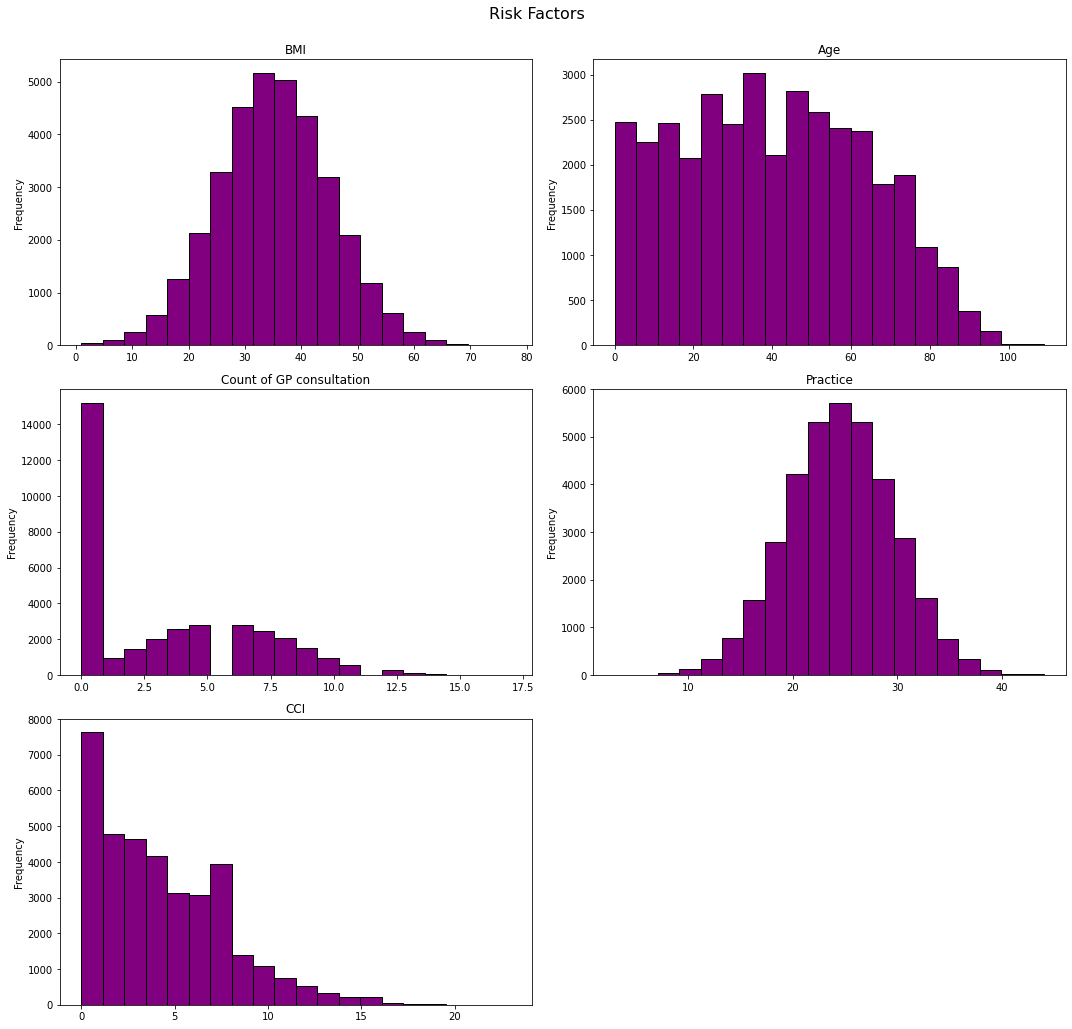

In [18]:
fig, axes = plt.subplots(3,2, 
                        figsize=(15, 15)
                        )
create_histplot('BMI', data['bmi'], axes[0,0])
create_histplot('Age', data['age'], axes[0,1])
create_histplot('Count of GP consultation', data['gp_count'], axes[1,0])
create_histplot('Practice', data['practice'], axes[1,1])
create_histplot('CCI', data['CCI'], axes[2,0])
fig.delaxes(ax=axes[2,1])

fig.suptitle('Risk Factors', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])
#plt.tight_layout()
#plt.savefig('../output/hospitalisation_risk/risk_factors_cont.jpg')
plt.show()

In [19]:
print(list(data.columns))

['bmi_date_measured', 'smoking_status_date', 'most_recent_unclear_smoking_cat_date', 'flu_vaccine_med', 'flu_vaccine_clinical', 'antibacterial_prescriptions_date', 'sgss_positive', 'primary_care_covid', 'covrx1_dat', 'covrx2_dat', 'admitted_date', 'died_date', 'uti_date_1', 'uti_date_2', 'uti_date_3', 'uti_date_4', 'lrti_date_1', 'lrti_date_2', 'lrti_date_3', 'lrti_date_4', 'urti_date_1', 'urti_date_2', 'urti_date_3', 'urti_date_4', 'sinusitis_date_1', 'sinusitis_date_2', 'sinusitis_date_3', 'sinusitis_date_4', 'otmedia_date_1', 'otmedia_date_2', 'otmedia_date_3', 'otmedia_date_4', 'ot_externa_date_1', 'ot_externa_date_2', 'ot_externa_date_3', 'ot_externa_date_4', 'gp_cons_uti_1', 'gp_cons_uti_2', 'gp_cons_uti_3', 'gp_cons_uti_4', 'gp_cons_lrti_1', 'gp_cons_lrti_2', 'gp_cons_lrti_3', 'gp_cons_lrti_4', 'gp_cons_sinusitis_1', 'gp_cons_sinusitis_2', 'gp_cons_sinusitis_3', 'gp_cons_sinusitis_4', 'gp_cons_otmedia_1', 'gp_cons_otmedia_2', 'gp_cons_otmedia_3', 'gp_cons_otmedia_4', 'gp_cons_ot

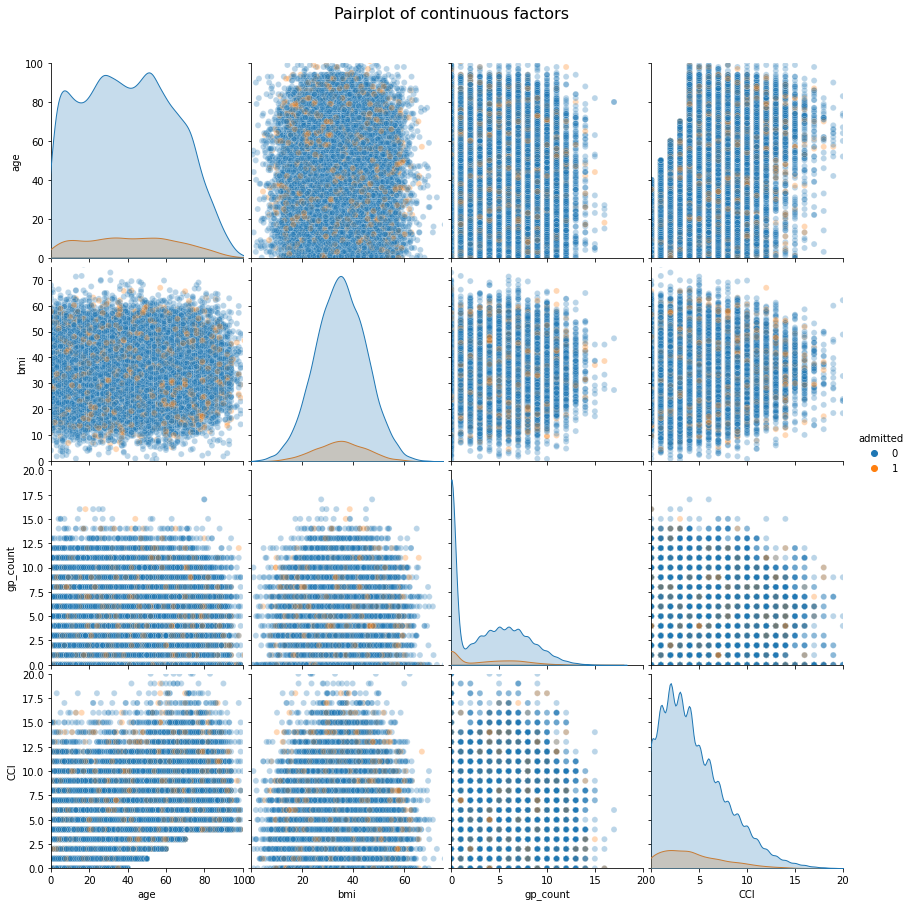

In [20]:
p = sns.pairplot(data, vars=['age', 'bmi', 'gp_count', 'CCI'#, 'practice'
                             ], 
                hue = 'admitted', # 'antibacterial_brit', 
#                kind='reg', 
                #markers=["o", "s"], 
                diag_kind="kde",#"hist"
#                plot_kws={#'line_kws':{'color':'red'}, 
                plot_kws={'alpha':0.3},
                height = 3)

p.axes[0,2].set_xlim((0,20))
p.axes[0,2].set_ylim((0,100))

p.axes[1,1].set_xlim((0,75))
p.axes[1,1].set_ylim((0,75))

p.axes[2,0].set_xlim((0,100))
p.axes[2,0].set_ylim((0,20))

p.axes[0,3].set_xlim((0,20))
p.axes[3,0].set_ylim((0,20))

plt.suptitle('Pairplot of continuous factors', fontsize=16, y=1.05)
#plt.savefig('../output/hospitalisation_risk/risk_factors_cont_pairplot.jpg')
plt.show()

### 2-2- Categorical factors

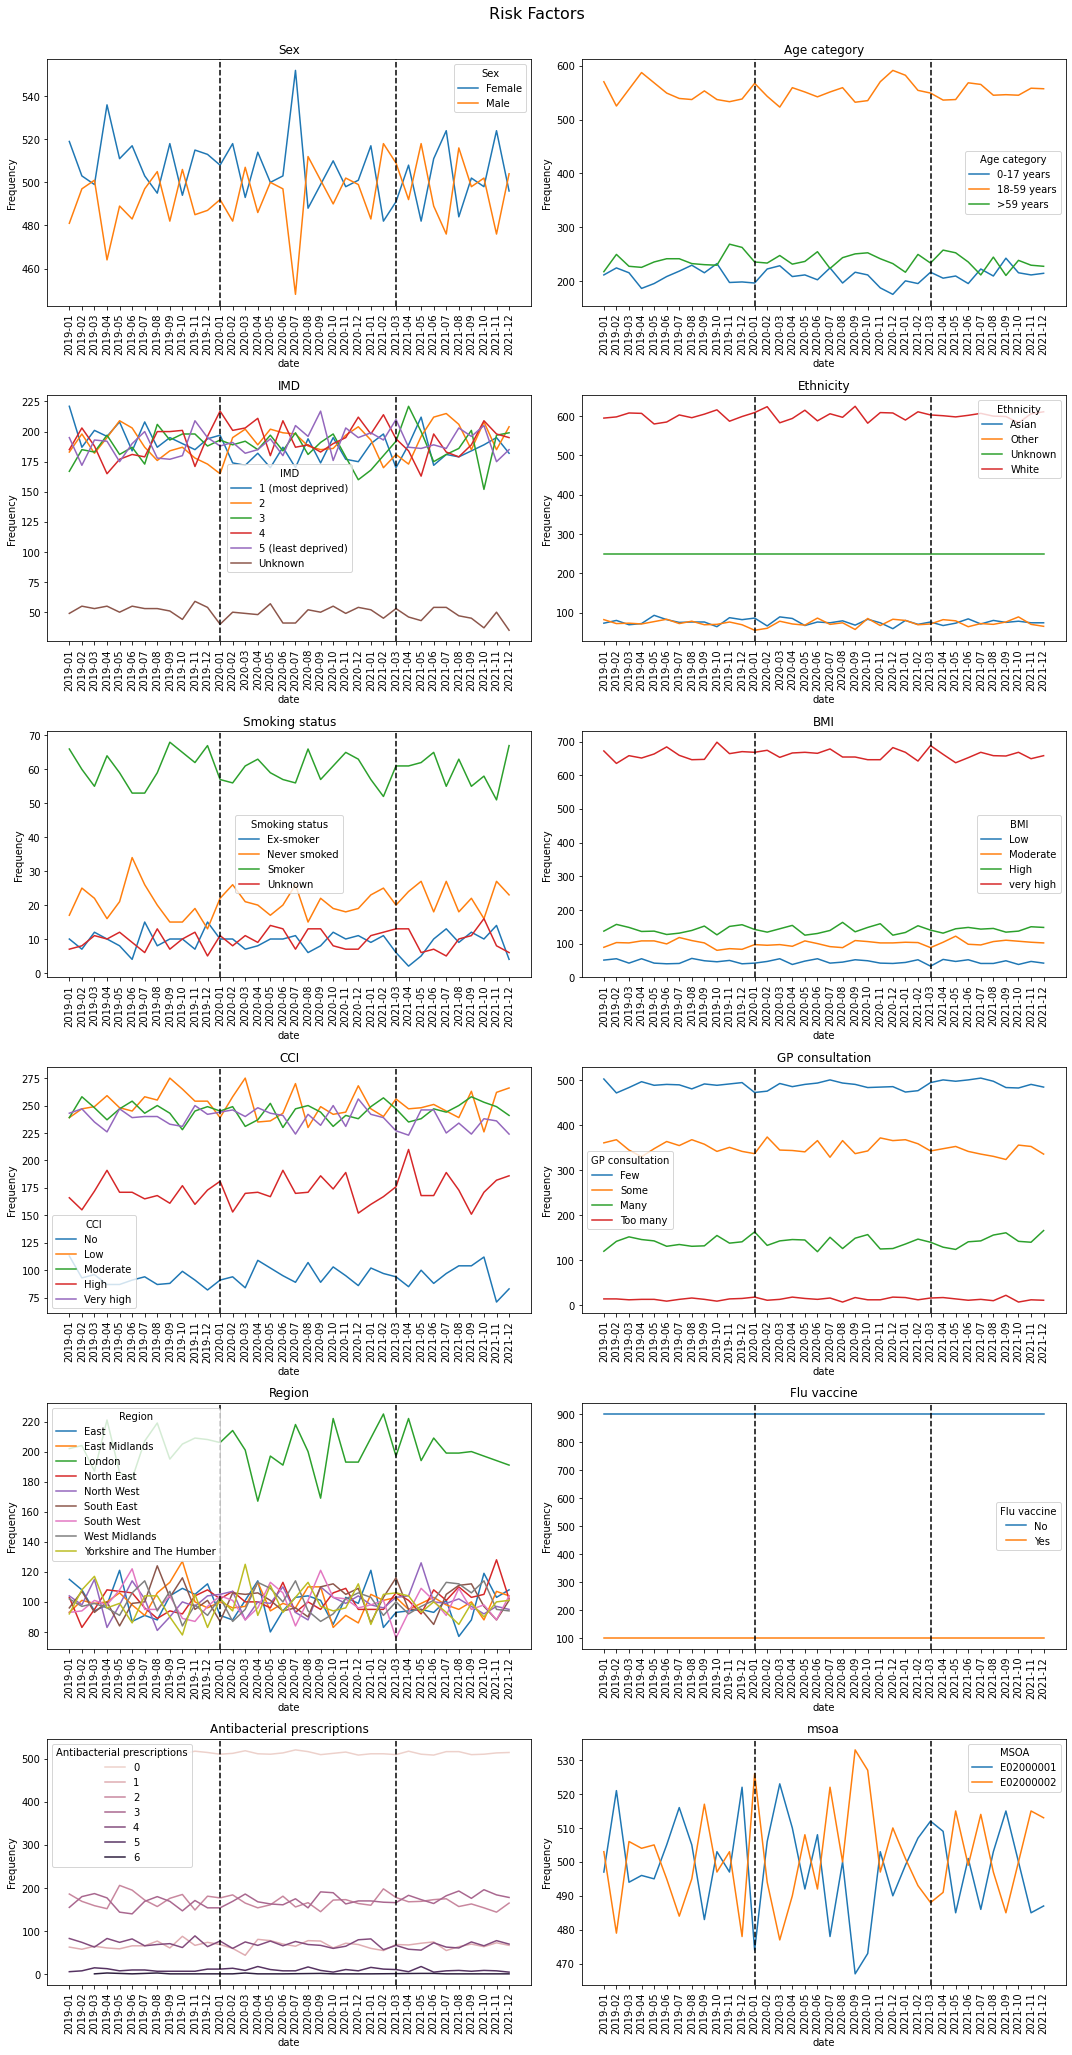

In [19]:
fig, axes = plt.subplots(6,2,
                        figsize=(15, 30)
                        )
create_lineplot('sex', 'Sex', 'Sex', axes[0,0])
create_lineplot('Age_cat', 'Age category', 'Age category', axes[0,1])
create_lineplot('imd', 'IMD', 'IMD', axes[1,0])
create_lineplot('ethnicity', 'Ethnicity', 'Ethnicity', axes[1,1])
create_lineplot('smoking_status', 'Smoking status', 'Smoking status', axes[2,0])
create_lineplot('BMI_cat', 'BMI', 'BMI', axes[2,1])
create_lineplot('CCI_cat', 'CCI', 'CCI', axes[3,0])
create_lineplot('gp_count_cat', 'GP consultation', 'GP consultation', axes[3,1])
create_lineplot('region', 'Region', 'Region', axes[4,0])
create_lineplot('flu_vaccine', 'Flu vaccine', 'Flu vaccine', axes[4,1])
create_lineplot('antibacterial_brit', 'Antibacterial prescriptions', 'Antibacterial prescriptions', axes[5,0])
create_lineplot('msoa', 'msoa', 'MSOA', axes[5,1])
#fig.delaxes(ax=axes[4,1])

fig.suptitle('Risk Factors', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])
#plt.tight_layout()
#plt.savefig('../output/hospitalisation_risk/risk_factors_cat.jpg')
plt.show()

## 3- Data preparation
This includes data type conversion and exclusion of cases that are not considered in the infection-related hospital admission, i.e. those who were diagnosed with Covid19 three months (=90 days) before and one month (=30 days) after hospital admission.

### 3-1- UTI

In [18]:
data['admitted_uti_date_1'] = data['admitted_uti_date_1'].astype('datetime64[ns]')
data['admitted_uti_date_2'] = data['admitted_uti_date_2'].astype('datetime64[ns]')
data['admitted_uti_date_3'] = data['admitted_uti_date_3'].astype('datetime64[ns]')
data['admitted_uti_date_4'] = data['admitted_uti_date_4'].astype('datetime64[ns]')

In [19]:
data

,bmi_date_measured,smoking_status_date,most_recent_unclear_smoking_cat_date,flu_vaccine_med,flu_vaccine_clinical,antibacterial_prescriptions_date,sgss_positive,primary_care_covid,covrx1_dat,covrx2_dat,...,mi_comor,peptic_ulcer_comor,peripheral_vascular_comor,patient_id,date,CCI,BMI_cat,gp_count_cat,CCI_cat,Age_cat
0,2019-02,NaN,2019-07,NaN,NaN,NaN,NaN,2019-06-04,NaN,NaN,...,0,0,0,4894,2019-01,5.0,very high,Some,High,>59 years
1,2021-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1,0,8992,2019-01,8.0,High,Many,Very high,18-59 years
2,2020-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-07-27,...,0,0,0,8747,2019-01,0.0,very high,Few,No,18-59 years
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-10-20,...,0,0,0,2044,2019-01,1.0,NaN,Some,Low,18-59 years
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,6169,2019-01,7.0,NaN,Few,Very high,18-59 years
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35995,2020-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,5613,2021-12,4.0,very high,Some,Moderate,>59 years
35996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,3438,2021-12,0.0,NaN,Many,No,0-17 years
35997,2020-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,2383,2021-12,6.0,very high,Some,High,>59 years
35998,2019-06,NaN,2021-05,NaN,2018-07,NaN,NaN,NaN,NaN,NaN,...,0,0,0,5773,2021-12,7.0,very high,Some,Very high,>59 years


In [20]:
print(list(data.columns))

['bmi_date_measured', 'smoking_status_date', 'most_recent_unclear_smoking_cat_date', 'flu_vaccine_med', 'flu_vaccine_clinical', 'antibacterial_prescriptions_date', 'sgss_positive', 'primary_care_covid', 'covrx1_dat', 'covrx2_dat', 'admitted_date', 'died_date', 'uti_date_1', 'uti_date_2', 'uti_date_3', 'uti_date_4', 'lrti_date_1', 'lrti_date_2', 'lrti_date_3', 'lrti_date_4', 'urti_date_1', 'urti_date_2', 'urti_date_3', 'urti_date_4', 'sinusitis_date_1', 'sinusitis_date_2', 'sinusitis_date_3', 'sinusitis_date_4', 'otmedia_date_1', 'otmedia_date_2', 'otmedia_date_3', 'otmedia_date_4', 'ot_externa_date_1', 'ot_externa_date_2', 'ot_externa_date_3', 'ot_externa_date_4', 'gp_cons_uti_1', 'gp_cons_uti_2', 'gp_cons_uti_3', 'gp_cons_uti_4', 'gp_cons_lrti_1', 'gp_cons_lrti_2', 'gp_cons_lrti_3', 'gp_cons_lrti_4', 'gp_cons_sinusitis_1', 'gp_cons_sinusitis_2', 'gp_cons_sinusitis_3', 'gp_cons_sinusitis_4', 'gp_cons_otmedia_1', 'gp_cons_otmedia_2', 'gp_cons_otmedia_3', 'gp_cons_otmedia_4', 'gp_cons_ot

In [21]:
data.prevl_uti_date_1.value_counts()

0    32400
1     3600
Name: prevl_uti_date_1, dtype: int64

In [22]:
data.gp_cons_uti_1.value_counts()

2019-11-18    10
2019-11-27     9
2019-06-20     9
2020-11-27     9
2019-11-06     9
              ..
2019-02-25     1
2020-04-16     1
2021-05-22     1
2019-12-07     1
2019-03-09     1
Name: gp_cons_uti_1, Length: 1095, dtype: int64

#### UTI-1

In [23]:
data_uti_1 = data[['age', 'age_cat', 'sex', 'bmi', 'BMI_cat', 'gp_count', 'flu_vaccine', 'region', 'antibacterial_brit',
                    'imd', 'ethnicity', 'CCI_cat', 'CCI', 'hx_hosp', 'died_date',
                    'gp_cons_uti_1', 'gp_cons_uti_ab_1',
                    'uti_date_1', 'incdt_uti_date_1', 'prevl_uti_date_1', 'admitted_uti_date_1',
                    'sgss_gp_cov_uti_date_1']]

data_uti_1 = data_uti_1[data_uti_1['uti_date_1'].notnull()]

data_uti_1.shape

(3600, 22)

In [24]:
# exclusion of covid positive 90 days before and 30 days after dx with uti_1
data_uti_1 = data_uti_1[data_uti_1['sgss_gp_cov_uti_date_1'] == 0]
data_uti_1.shape

(3247, 22)

In [25]:
data_uti_1.columns

Index(['age', 'age_cat', 'sex', 'bmi', 'BMI_cat', 'gp_count', 'flu_vaccine',
       'region', 'antibacterial_brit', 'imd', 'ethnicity', 'CCI_cat', 'CCI',
       'hx_hosp', 'died_date', 'gp_cons_uti_1', 'gp_cons_uti_ab_1',
       'uti_date_1', 'incdt_uti_date_1', 'prevl_uti_date_1',
       'admitted_uti_date_1', 'sgss_gp_cov_uti_date_1'],
      dtype='object')

#### UTI-2

In [26]:
data_uti_2 = data[['age', 'age_cat', 'sex', 'bmi', 'BMI_cat', 'gp_count', 'flu_vaccine', 'region', 'antibacterial_brit',
                    'imd', 'ethnicity', 'CCI_cat', 'CCI', 'hx_hosp', 'died_date',
                    'gp_cons_uti_2', 'gp_cons_uti_ab_2',
                    'uti_date_2', 'incdt_uti_date_2', 'prevl_uti_date_2', 'admitted_uti_date_2',
                    'sgss_gp_cov_uti_date_2']]

data_uti_2 = data_uti_2[data_uti_2['uti_date_2'].notnull()]

data_uti_2.shape

(3600, 22)

In [27]:
# exclusion of covid positive 90 days before and 30 days after dx with uti_2
data_uti_2 = data_uti_2[data_uti_2['sgss_gp_cov_uti_date_2'] == 0]
data_uti_2.shape

(3255, 22)

In [28]:
data_uti_2.columns

Index(['age', 'age_cat', 'sex', 'bmi', 'BMI_cat', 'gp_count', 'flu_vaccine',
       'region', 'antibacterial_brit', 'imd', 'ethnicity', 'CCI_cat', 'CCI',
       'hx_hosp', 'died_date', 'gp_cons_uti_2', 'gp_cons_uti_ab_2',
       'uti_date_2', 'incdt_uti_date_2', 'prevl_uti_date_2',
       'admitted_uti_date_2', 'sgss_gp_cov_uti_date_2'],
      dtype='object')

#### UTI_3

In [29]:
data_uti_3 = data[['age', 'age_cat', 'sex', 'bmi', 'BMI_cat', 'gp_count', 'flu_vaccine', 'region', 'antibacterial_brit',
                    'imd', 'ethnicity', 'CCI_cat', 'CCI', 'hx_hosp', 'died_date',
                    'gp_cons_uti_3', 'gp_cons_uti_ab_3',
                    'uti_date_3', 'incdt_uti_date_3', 'prevl_uti_date_3', 'admitted_uti_date_3',
                    'sgss_gp_cov_uti_date_3']]

data_uti_3 = data_uti_3[data_uti_3['uti_date_3'].notnull()]

data_uti_3.shape

(3600, 22)

In [30]:
# exclusion of covid positive 90 days before and 30 days after dx with uti_3
data_uti_3 = data_uti_3[data_uti_3['sgss_gp_cov_uti_date_3'] == 0]
data_uti_3.shape

(3237, 22)

In [31]:
data_uti_3.columns

Index(['age', 'age_cat', 'sex', 'bmi', 'BMI_cat', 'gp_count', 'flu_vaccine',
       'region', 'antibacterial_brit', 'imd', 'ethnicity', 'CCI_cat', 'CCI',
       'hx_hosp', 'died_date', 'gp_cons_uti_3', 'gp_cons_uti_ab_3',
       'uti_date_3', 'incdt_uti_date_3', 'prevl_uti_date_3',
       'admitted_uti_date_3', 'sgss_gp_cov_uti_date_3'],
      dtype='object')

#### UTI_4

In [32]:
data_uti_4 = data[['age', 'age_cat', 'sex', 'bmi', 'BMI_cat', 'gp_count', 'flu_vaccine', 'region', 'antibacterial_brit',
                    'imd', 'ethnicity', 'CCI_cat', 'CCI', 'hx_hosp', 'died_date',
                    'gp_cons_uti_4', 'gp_cons_uti_ab_4',
                    'uti_date_4', 'incdt_uti_date_4', 'prevl_uti_date_4', 'admitted_uti_date_4',
                    'sgss_gp_cov_uti_date_4']]

data_uti_4 = data_uti_4[data_uti_4['uti_date_4'].notnull()]

data_uti_4.shape

(3600, 22)

In [33]:
# exclusion of covid positive 90 days before and 30 days after dx with uti_4
data_uti_4 = data_uti_4[data_uti_4['sgss_gp_cov_uti_date_4'] == 0]
data_uti_4.shape

(3261, 22)

In [34]:
data_uti_4

,age,age_cat,sex,bmi,BMI_cat,gp_count,flu_vaccine,region,antibacterial_brit,imd,...,CCI,hx_hosp,died_date,gp_cons_uti_4,gp_cons_uti_ab_4,uti_date_4,incdt_uti_date_4,prevl_uti_date_4,admitted_uti_date_4,sgss_gp_cov_uti_date_4
35,33,5-14,Female,18.048983,Low,8.0,No,North West,0,1 (most deprived),...,8.0,1,NaN,NaN,NaN,2021-06-01,NaN,1,NaT,0
38,18,25-34,Male,36.955752,very high,7.0,No,Yorkshire and The Humber,2,2,...,7.0,0,2022-01-10,NaN,NaN,2021-12-31,2019-08-04,0,NaT,0
50,20,55-64,Female,33.286822,very high,2.0,No,South West,0,2,...,8.0,0,NaN,2020-01-13,NaN,2020-10-25,NaN,0,NaT,0
51,68,5-14,Female,NaN,NaN,7.0,No,East Midlands,1,4,...,6.0,0,NaN,NaN,NaN,2019-08-15,NaN,0,NaT,0
56,46,45-54,Female,40.998192,very high,11.0,No,West Midlands,0,3,...,1.0,0,NaN,NaN,NaN,2020-03-06,NaN,0,NaT,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35971,31,0-4,Male,17.450027,Low,5.0,No,East Midlands,2,1 (most deprived),...,1.0,0,2021-11-20,NaN,NaN,2020-09-03,NaN,0,NaT,0
35989,34,15-24,Female,62.762469,very high,0.0,No,Yorkshire and The Humber,0,Unknown,...,5.0,1,NaN,NaN,NaN,2020-07-28,NaN,1,NaT,0
35996,8,65-74,Male,NaN,NaN,8.0,No,East Midlands,3,4,...,0.0,1,NaN,NaN,NaN,2020-01-14,NaN,0,2019-03-23,0
35997,75,35-44,Male,40.785798,very high,4.0,No,East,2,4,...,6.0,1,NaN,NaN,NaN,2019-11-01,NaN,1,NaT,0


In [35]:
data_uti_4.columns

Index(['age', 'age_cat', 'sex', 'bmi', 'BMI_cat', 'gp_count', 'flu_vaccine',
       'region', 'antibacterial_brit', 'imd', 'ethnicity', 'CCI_cat', 'CCI',
       'hx_hosp', 'died_date', 'gp_cons_uti_4', 'gp_cons_uti_ab_4',
       'uti_date_4', 'incdt_uti_date_4', 'prevl_uti_date_4',
       'admitted_uti_date_4', 'sgss_gp_cov_uti_date_4'],
      dtype='object')

#### Combining UTI_1, UTI_2, UTI_3, and UTI_4

In [36]:
data_uti_1.rename(columns={'uti_date_1': 'uti_date', 'incdt_uti_date_1': 'incdt_uti_date', 
                           'gp_cons_uti_1': 'gp_cons_uti', 'gp_cons_uti_ab_1': 'gp_cons_uti_ab',
                           'incdt_uti_date_1': 'incdt_uti_date', 'prevl_uti_date_1': 'prevl_uti_date',
                           'admitted_uti_date_1': 'admitted_uti_date',
                           'sgss_gp_cov_uti_date_1': 'sgss_gp_cov_uti_date'},
                inplace=True)
data_uti_2.rename(columns={'uti_date_2': 'uti_date', 'incdt_uti_date_2': 'incdt_uti_date',
                           'gp_cons_uti_2': 'gp_cons_uti', 'gp_cons_uti_ab_2': 'gp_cons_uti_ab',
                           'incdt_uti_date_2': 'incdt_uti_date', 'prevl_uti_date_2': 'prevl_uti_date', 
                           'admitted_uti_date_2': 'admitted_uti_date',
                           'sgss_gp_cov_uti_date_2': 'sgss_gp_cov_uti_date'},
                inplace=True)
data_uti_3.rename(columns={'uti_date_3': 'uti_date', 'incdt_uti_date_3': 'incdt_uti_date',
                           'gp_cons_uti_3': 'gp_cons_uti', 'gp_cons_uti_ab_3': 'gp_cons_uti_ab',
                           'incdt_uti_date_3': 'incdt_uti_date', 'prevl_uti_date_3': 'prevl_uti_date', 
                           'admitted_uti_date_3': 'admitted_uti_date',
                           'sgss_gp_cov_uti_date_3': 'sgss_gp_cov_uti_date'},
                 inplace=True)
data_uti_4.rename(columns={'uti_date_4': 'uti_date', 'incdt_uti_date_4': 'incdt_uti_date', 
                           'gp_cons_uti_4': 'gp_cons_uti', 'gp_cons_uti_ab_4': 'gp_cons_uti_ab',
                           'incdt_uti_date_4': 'incdt_uti_date', 'prevl_uti_date_4': 'prevl_uti_date',
                           'admitted_uti_date_4': 'admitted_uti_date',
                           'sgss_gp_cov_uti_date_4': 'sgss_gp_cov_uti_date'}, 
                 inplace=True)

data_uti = pd.concat([data_uti_1, data_uti_2, data_uti_3, data_uti_4])
data_uti.reset_index(inplace=True, drop=True)
data_uti.shape

(13000, 22)

In [37]:
data_uti.columns

Index(['age', 'age_cat', 'sex', 'bmi', 'BMI_cat', 'gp_count', 'flu_vaccine',
       'region', 'antibacterial_brit', 'imd', 'ethnicity', 'CCI_cat', 'CCI',
       'hx_hosp', 'died_date', 'gp_cons_uti', 'gp_cons_uti_ab', 'uti_date',
       'incdt_uti_date', 'prevl_uti_date', 'admitted_uti_date',
       'sgss_gp_cov_uti_date'],
      dtype='object')

#### Adding event and duration columns

In [39]:
data_uti['admitted_uti_date'] = data_uti['admitted_uti_date'].astype('datetime64[ns]')
data_uti['uti_date'] = data_uti['uti_date'].astype('datetime64[ns]')
data_uti['incdt_uti_date'] = data_uti['incdt_uti_date'].astype('datetime64[ns]')
data_uti['died_date'] = data_uti['died_date'].astype('datetime64[ns]')

In [40]:
# drop any case that has no admitted_uti_date
data_uti = data_uti[data_uti['admitted_uti_date'].notnull()]

In [41]:
#I should ensure that incdt_uti_date is the same as uti_date and then apply this section for the entire uti data
# data_uti['delta_uti_admitted'] = (data_uti['admitted_uti_date'] - data_uti['incdt_uti_date']).dt.days
data_uti['delta_uti_admitted'] = (data_uti['admitted_uti_date'] - data_uti['uti_date']).dt.days
data_uti['delta_uti_admitted'].value_counts()

 8      10
-95      9
 73      8
 32      8
-78      8
        ..
-479     1
 115     1
-89      1
-653     1
-18      1
Name: delta_uti_admitted, Length: 1615, dtype: int64

In [541]:
# # I deactivate this cell because I think dummy data leads to  
# data_uti.loc[data_uti['delta_uti_admitted'] > 30, 'delta_uti_admitted'] = 0
# data_uti.loc[data_uti['delta_uti_admitted'] < 0, 'delta_uti_admitted'] = 0 
# data_uti['delta_uti_admitted'].value_counts()

In [42]:
data_uti['delta_admitted_died'] = (data_uti['died_date'] - data_uti['admitted_uti_date']).dt.days

#give nan to any case that died before admission! (this happens because of dummy data??)
# data_uti.loc[data_uti['delta_uti_admitted'] < 0, 'delta_uti_admitted'] = np.nan
data_uti = data_uti[data_uti['delta_uti_admitted'] > 0]

data_uti['delta_admitted_died'].isnull().sum()

1786

In [43]:
#censor died cases
data_uti.loc[data_uti['delta_admitted_died'] > 30, 'event_uti_admitted'] = 0
data_uti['event_uti_admitted'].value_counts()

0.0    137
Name: event_uti_admitted, dtype: int64

In [44]:
#censor cases that had a history of hospital admission
data_uti.loc[data_uti['hx_hosp'] == 1, 'event_uti_admitted'] = 0
data_uti['event_uti_admitted'].value_counts()

0.0    524
Name: event_uti_admitted, dtype: int64

In [45]:
#uncensor any other cases
data_uti['event_uti_admitted'] = data_uti['event_uti_admitted'].replace(np.NaN, 1)
data_uti['event_uti_admitted'].value_counts()

1.0    1463
0.0     524
Name: event_uti_admitted, dtype: int64

In [46]:
#assign values for duration column
data_uti['duration_uti_admitted'] = data_uti['delta_uti_admitted'].combine_first(data_uti['delta_admitted_died'])
data_uti['duration_uti_admitted']#.value_counts()

7          25
13        564
19       1037
20         31
25        233
         ... 
12964     105
12965     683
12970      73
12972     370
12990     585
Name: duration_uti_admitted, Length: 1987, dtype: int64

In [47]:
data_uti#['duration_uti_admitted'].value_counts()

,age,age_cat,sex,bmi,BMI_cat,gp_count,flu_vaccine,region,antibacterial_brit,imd,...,gp_cons_uti_ab,uti_date,incdt_uti_date,prevl_uti_date,admitted_uti_date,sgss_gp_cov_uti_date,delta_uti_admitted,delta_admitted_died,event_uti_admitted,duration_uti_admitted
7,46,5-14,Female,34.525734,very high,7.0,No,East Midlands,3,3,...,NaN,2019-02-28,NaT,0,2019-03-25,0,25,976.0,0.0,25
13,68,75+,Female,48.875178,very high,10.0,No,West Midlands,0,1 (most deprived),...,NaN,2019-09-27,NaT,0,2021-04-13,0,564,NaN,1.0,564
19,60,0-4,Female,35.370153,very high,1.0,No,South East,4,3,...,NaN,2019-01-07,NaT,0,2021-11-09,0,1037,NaN,1.0,1037
20,43,75+,Male,52.969867,very high,0.0,No,East Midlands,0,4,...,NaN,2020-02-15,NaT,0,2020-03-17,0,31,NaN,1.0,31
25,33,55-64,Female,47.467993,very high,0.0,No,London,0,1 (most deprived),...,NaN,2019-10-17,NaT,0,2020-06-06,0,233,NaN,1.0,233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12964,41,0-4,Female,33.282446,very high,2.0,No,London,3,3,...,NaN,2019-05-12,NaT,0,2019-08-25,0,105,NaN,1.0,105
12965,41,55-64,Female,48.502300,very high,0.0,Yes,West Midlands,0,3,...,NaN,2020-02-27,NaT,0,2022-01-10,0,683,NaN,1.0,683
12970,78,45-54,Female,30.117349,very high,0.0,No,London,0,4,...,NaN,2021-08-18,NaT,0,2021-10-30,0,73,NaN,1.0,73
12972,17,45-54,Male,17.583665,Low,0.0,No,London,0,5 (least deprived),...,NaN,2019-09-13,NaT,0,2020-09-17,0,370,NaN,1.0,370


In [ ]:
# fig, ax = plt.subplots(figsize=(9, 7))
# sns.heatmap(data_uti[['age', 'bmi', 'CCI', 'antibacterial_brit', 'gp_count' ]].corr(), 
#             annot=True, fmt=".2f", annot_kws={"size":12},
#             vmin=-1.0, vmax=1.0)

# ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions', 'GP consultations' ], rotation=90, fontsize=12)
# ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions', 'GP consultations' ], rotation=0, fontsize=12)                        
# plt.tight_layout()
# #plt.savefig('../output/hospitalisation_risk/corr_hospitalisation.jpg')
# plt.show()

#### Separate data of UTI
We separate data of UTI to form four sub-datasets for 1) no antibiotics and incident admission, 2) with antibiotics and incident admission, 3) no antibiotics and prevalent admission, and 4) with antiobiotics and prevalent admission.

In [48]:
# no antibiotics and incident hospital admission
#data_uti_no_abs_incdt = data_uti[~data_uti['gp_cons_uti_ab'].notnull() & data_uti['incdt_uti_date'].notnull()]
data_uti_no_abs_incdt = data_uti[data_uti['gp_cons_uti_ab'].isnull()]
data_uti_no_abs_incdt = data_uti_no_abs_incdt[data_uti_no_abs_incdt['incdt_uti_date'].notnull()]
data_uti_no_abs_incdt.shape

(182, 26)

In [49]:
# with antibiotics and incident hospital admission
#data_uti_abs_incdt = data_uti[data_uti['gp_cons_uti_ab'].notnull() & data_uti['incdt_uti_date'].notnull()]
data_uti_abs_incdt = data_uti[data_uti['gp_cons_uti_ab'].notnull()]
data_uti_abs_incdt = data_uti_abs_incdt[data_uti_abs_incdt['incdt_uti_date'].notnull()]
data_uti_abs_incdt.shape

(24, 26)

In [50]:
# no antibiotics and prevalent hospital admission
#data_uti_no_abs_prevl = data_uti[~data_uti['gp_cons_uti_ab'].notnull() & data_uti['prevl_uti_date'] == 1]
data_uti_no_abs_prevl = data_uti[data_uti['gp_cons_uti_ab'].isnull()]
data_uti_no_abs_prevl = data_uti_no_abs_prevl[data_uti_no_abs_prevl['uti_date'].notnull()]
data_uti_no_abs_prevl = data_uti_no_abs_prevl[data_uti_no_abs_prevl['incdt_uti_date'].isnull()]
#data_uti_no_abs_prevl = data_uti_no_abs_prevl[data_uti_no_abs_prevl['prevl_uti_date'] == 1]
data_uti_no_abs_prevl.shape

(1612, 26)

In [51]:
# with antibiotics and prevalent hospital admission
#data_uti_no_abs_prevl = data_uti[data_uti['gp_cons_uti_ab'].notnull() & data_uti['prevl_uti_date'] == 0]
data_uti_abs_prevl = data_uti[data_uti['gp_cons_uti_ab'].notnull()]
data_uti_abs_prevl = data_uti_abs_prevl[data_uti_abs_prevl['uti_date'].notnull()]
data_uti_abs_prevl = data_uti_abs_prevl[data_uti_abs_prevl['incdt_uti_date'].isnull()]
#data_uti_abs_prevl = data_uti_abs_prevl[data_uti_abs_prevl['prevl_uti_date'] == 1]
data_uti_abs_prevl.shape

(169, 26)

### 3-2- URTI

In [80]:
data['admitted_urti_date_1'] = data['admitted_urti_date_1'].astype('datetime64[ns]')
data['admitted_urti_date_2'] = data['admitted_urti_date_2'].astype('datetime64[ns]')
data['admitted_urti_date_3'] = data['admitted_urti_date_3'].astype('datetime64[ns]')
data['admitted_urti_date_4'] = data['admitted_urti_date_4'].astype('datetime64[ns]')

#### URTI-1

In [85]:
data_urti_1 = data[['age', 'age_cat', 'sex', 'bmi', 'BMI_cat', 'gp_count', 'flu_vaccine', 'region', 'antibacterial_brit',
                    'imd', 'ethnicity', 'CCI_cat', 'CCI', 'hx_hosp', 'died_date',
                    'gp_cons_urti_1', 'gp_cons_urti_ab_1',
                    'urti_date_1', 'incdt_urti_date_1', 'prevl_urti_date_1', 'admitted_urti_date_1',
                    'sgss_gp_cov_urti_date_1']]

data_urti_1 = data_urti_1[data_urti_1['urti_date_1'].notnull()]

data_urti_1.shape

(96, 22)

In [86]:
# exclusion of covid positive 90 days before and 30 days after dx with urti_1
data_urti_1 = data_urti_1[data_urti_1['sgss_gp_cov_urti_date_1'] == 0]
data_urti_1.shape

(90, 22)

In [87]:
data_urti_1.columns

Index(['age', 'age_cat', 'sex', 'bmi', 'BMI_cat', 'gp_count', 'flu_vaccine',
       'region', 'antibacterial_brit', 'imd', 'ethnicity', 'CCI_cat', 'CCI',
       'hx_hosp', 'died_date', 'gp_cons_urti_1', 'gp_cons_urti_ab_1',
       'urti_date_1', 'incdt_urti_date_1', 'prevl_urti_date_1',
       'admitted_urti_date_1', 'sgss_gp_cov_urti_date_1'],
      dtype='object')

#### URTI-2

In [88]:
data_urti_2 = data[['age', 'age_cat', 'sex', 'bmi', 'BMI_cat', 'gp_count', 'flu_vaccine', 'region', 'antibacterial_brit',
                    'imd', 'ethnicity', 'CCI_cat', 'CCI', 'hx_hosp', 'died_date',
                    'gp_cons_urti_2', 'gp_cons_urti_ab_2',
                    'urti_date_2', 'incdt_urti_date_2', 'prevl_urti_date_2', 'admitted_urti_date_2',
                    'sgss_gp_cov_urti_date_2']]

data_urti_2 = data_urti_2[data_urti_2['urti_date_2'].notnull()]

data_urti_2.shape

(80, 22)

In [90]:
# exclusion of covid positive 90 days before and 30 days after dx with urti_2
data_urti_2 = data_urti_2[data_urti_2['sgss_gp_cov_urti_date_2'] == 0]
data_urti_2.shape

(75, 22)

In [91]:
data_urti_2.columns

Index(['age', 'age_cat', 'sex', 'bmi', 'BMI_cat', 'gp_count', 'flu_vaccine',
       'region', 'antibacterial_brit', 'imd', 'ethnicity', 'CCI_cat', 'CCI',
       'hx_hosp', 'died_date', 'gp_cons_urti_2', 'gp_cons_urti_ab_2',
       'urti_date_2', 'incdt_urti_date_2', 'prevl_urti_date_2',
       'admitted_urti_date_2', 'sgss_gp_cov_urti_date_2'],
      dtype='object')

#### URTI-3

In [92]:
data_urti_3 = data[['age', 'age_cat', 'sex', 'bmi', 'BMI_cat', 'gp_count', 'flu_vaccine', 'region', 'antibacterial_brit',
                    'imd', 'ethnicity', 'CCI_cat', 'CCI', 'hx_hosp', 'died_date',
                    'gp_cons_urti_3', 'gp_cons_urti_ab_3',
                    'urti_date_3', 'incdt_urti_date_3', 'prevl_urti_date_3', 'admitted_urti_date_3',
                    'sgss_gp_cov_urti_date_3']]

data_urti_3 = data_urti_3[data_urti_3['urti_date_3'].notnull()]

data_urti_3.shape

(91, 22)

In [93]:
# exclusion of covid positive 90 days before and 30 days after dx with urti_3
data_uti_3 = data_urti_3[data_urti_3['sgss_gp_cov_urti_date_3'] == 0]
data_urti_3.shape

(91, 22)

In [94]:
data_urti_3.columns

Index(['age', 'age_cat', 'sex', 'bmi', 'BMI_cat', 'gp_count', 'flu_vaccine',
       'region', 'antibacterial_brit', 'imd', 'ethnicity', 'CCI_cat', 'CCI',
       'hx_hosp', 'died_date', 'gp_cons_urti_3', 'gp_cons_urti_ab_3',
       'urti_date_3', 'incdt_urti_date_3', 'prevl_urti_date_3',
       'admitted_urti_date_3', 'sgss_gp_cov_urti_date_3'],
      dtype='object')

#### URTI-4

In [95]:
data_urti_4 = data[['age', 'age_cat', 'sex', 'bmi', 'BMI_cat', 'gp_count', 'flu_vaccine', 'region', 'antibacterial_brit',
                    'imd', 'ethnicity', 'CCI_cat', 'CCI', 'hx_hosp', 'died_date',
                    'gp_cons_urti_4', 'gp_cons_urti_ab_4',
                    'urti_date_4', 'incdt_urti_date_4', 'prevl_urti_date_4', 'admitted_urti_date_4',
                    'sgss_gp_cov_urti_date_4']]

data_urti_4 = data_urti_4[data_urti_4['urti_date_4'].notnull()]

data_urti_4.shape

(83, 22)

In [96]:
# exclusion of covid positive 90 days before and 30 days after dx with urti_4
data_urti_4 = data_urti_4[data_urti_4['sgss_gp_cov_urti_date_4'] == 0]
data_urti_4.shape

(73, 22)

In [98]:
data_urti_4.columns

Index(['age', 'age_cat', 'sex', 'bmi', 'BMI_cat', 'gp_count', 'flu_vaccine',
       'region', 'antibacterial_brit', 'imd', 'ethnicity', 'CCI_cat', 'CCI',
       'hx_hosp', 'died_date', 'gp_cons_urti_4', 'gp_cons_urti_ab_4',
       'urti_date_4', 'incdt_urti_date_4', 'prevl_urti_date_4',
       'admitted_urti_date_4', 'sgss_gp_cov_urti_date_4'],
      dtype='object')

## 4- Cox modelling for hospital admissions related to infections 
### 4-1- UTI
#### 4-1-1- Incident hospital admission related to UTI with no antibiotics

In [553]:
data_uti_no_abs_incdt.columns

Index(['age', 'age_cat', 'sex', 'bmi', 'BMI_cat', 'gp_count', 'flu_vaccine',
       'region', 'antibacterial_brit', 'imd', 'ethnicity', 'CCI_cat', 'CCI',
       'hx_hosp', 'died_date', 'gp_cons_uti', 'gp_cons_uti_ab', 'uti_date',
       'incdt_uti_date', 'prevl_uti_date', 'admitted_uti_date',
       'sgss_gp_cov_uti_date', 'delta_uti_admitted', 'delta_admitted_died',
       'event_uti_admitted', 'duration_uti_admitted'],
      dtype='object')

In [554]:
data_uti_no_abs_incdt.shape

(160, 26)

In [560]:
#keep relevant variables
data_uti_no_abs_incdt = data_uti_no_abs_incdt[['age', 'age_cat', 'sex', 'bmi', 'BMI_cat', 'gp_count', 'flu_vaccine',
                                               'region', 'antibacterial_brit', 'imd', 'ethnicity', 'CCI_cat', 'CCI',
                                               'event_uti_admitted', 'duration_uti_admitted']]

In [561]:
# printing number of missing values in each variable 
data_uti_no_abs_incdt.isnull().sum()

age                      0
age_cat                  0
sex                      0
bmi                      6
BMI_cat                  6
gp_count                 0
flu_vaccine              0
region                   0
antibacterial_brit       0
imd                      0
ethnicity                0
CCI_cat                  0
CCI                      0
event_uti_admitted       0
duration_uti_admitted    0
dtype: int64

In [563]:
#drop ros with missing values
data_uti_no_abs_incdt = data_uti_no_abs_incdt.dropna(axis='rows')
# data_uti = data_uti.drop(columns=['smoking_status'])
data_uti_no_abs_incdt.isnull().sum()

age                      0
age_cat                  0
sex                      0
bmi                      0
BMI_cat                  0
gp_count                 0
flu_vaccine              0
region                   0
antibacterial_brit       0
imd                      0
ethnicity                0
CCI_cat                  0
CCI                      0
event_uti_admitted       0
duration_uti_admitted    0
dtype: int64

In [564]:
cph_uti_no_abs_incdt = CoxPHFitter()
cph_uti_no_abs_incdt.fit(data_uti_no_abs_incdt, 
        duration_col='duration_uti_admitted',
        event_col='event_uti_admitted',
        formula="age_cat + sex + gp_count + flu_vaccine + region + antibacterial_brit + imd + ethnicity"
        )
cph_uti_no_abs_incdt.print_summary()

<lifelines.CoxPHFitter: fitted with 154 total observations, 40 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 154
number of events observed = 114
   partial log-likelihood = -438.24
         time fit was run = 2022-02-02 19:18:23 UTC

---
                                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                  
age_cat[T.15-24]                    -0.52       0.59       0.55            -1.60             0.55                 0.20                 1.74
age_cat[T.25-34]                    -0.24       0.79       0.46            -1.13             0.66                 0.32                 1.93
age_cat[T.35-44]                    -0.18       0.84       0.36            -0.89             0.53                 0.41                 1.71
age_cat[T.45-54]                     0.53       1.69       0.43            -0.31             1.36                 0.74                 3.89
age_cat[T.5-14]                     -0.14       0.87       0.44            -1.01             0.73                 0.36                 2.07
age_cat[T.55-64]                    -0.16       0.85       0.39            -0.92             0.60                 0.40                 1.82
age_cat[T.65-74]                    -0.56       0.57       0.44            -1.42             0.31                 0.24                 1.36
age_cat[T.75+]                      -0.37       0.69       0.42            -1.19             0.46                 0.31                 1.58
antibacterial_brit                   0.17       1.18       0.08             0.01             0.32                 1.01                 1.38
ethnicity[T.Other]                   0.08       1.09       0.76            -1.40             1.57                 0.25                 4.80
ethnicity[T.Unknown]                 0.16       1.17       0.48            -0.79             1.10                 0.45                 3.01
ethnicity[T.White]                   0.01       1.01       0.45            -0.87             0.89                 0.42                 2.44
flu_vaccine[T.Yes]                  -0.90       0.41       0.39            -1.66            -0.14                 0.19                 0.87
gp_count                            -0.00       1.00       0.04            -0.07             0.07                 0.93                 1.07
imd[T.2]                            -0.07       0.93       0.34            -0.73             0.59                 0.48                 1.81
imd[T.3]                            -0.25       0.78       0.33            -0.90             0.40                 0.41                 1.49
imd[T.4]                            -0.31       0.73       0.33            -0.96             0.34                 0.38                 1.41
imd[T.5 (least deprived)]           -0.55       0.58       0.38            -1.30             0.20                 0.27                 1.23
imd[T.Unknown]                       1.73       5.63       0.56             0.63             2.83                 1.88                16.90
region[T.East Midlands]             -0.16       0.86       0.43            -1.00             0.69                 0.37                 1.99
region[T.London]                    -0.49       0.61       0.41            -1.30             0.31                 0.27                 1.37
region[T.North East]                -0.58       0.56       0.46            -1.49             0.33                 0.23                 1.39
region[T.North West]                -0.78       0.46       0.73            -2.21             0.65                 0.11                 1.92
region[T.South East]                -0.47       0.62       0.52            -1.49             0.55                 

NameError: name 'cph_uti_no_abs_incdt' is not defined

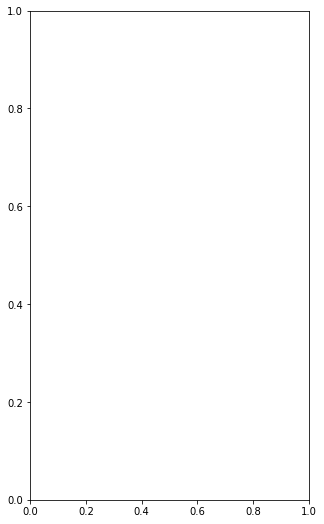

In [61]:
fig, ax = plt.subplots(figsize=(5, 9)
                        )
cph_uti_no_abs_incdt.plot()
plt.suptitle('Coefficients of CPH model for incident hospital admission related to UTI with no antibiotics', fontsize=16)
#_ = ax.set_yticklabels(['Age', 'BMI', 'GP consultations', 'CCI', 'IMD', 'Flu vaccine', 'Antibacterial prescriptions'], 
#                        rotation=45, fontsize=12, ha='right')
#plt.savefig('output/repeat_ABs_outputs/coefficients_cph_uti_no_abs_incdt.jpg', bbox_inches='tight')
plt.show()

In [ ]:
##save cph model with pickle package

# current_working_dir = os.getcwd()
# print(current_working_dir)

# with open('output/hospitalisation_prediction/cph_uti_abs_incdt.pickle', 'wb') as f:
#     pickle.dump(cph_uti_abs_incdt, f)

# with open('output/hospitalisation_prediction/cph_uti_abs_incdt.pickle', 'rb') as f:
#     cph_uti_abs_incdt = pickle.load(f)

# cph_uti_abs_incdt.summary

#### 4-1-2- Incident hospital admission related to UTI with antibiotics

In [53]:
data_uti_abs_incdt.columns

Index(['age', 'age_cat', 'sex', 'bmi', 'BMI_cat', 'gp_count', 'flu_vaccine',
       'region', 'antibacterial_brit', 'imd', 'ethnicity', 'CCI_cat', 'CCI',
       'hx_hosp', 'died_date', 'gp_cons_uti', 'gp_cons_uti_ab', 'uti_date',
       'incdt_uti_date', 'prevl_uti_date', 'admitted_uti_date',
       'sgss_gp_cov_uti_date', 'delta_uti_admitted', 'delta_admitted_died',
       'event_uti_admitted', 'duration_uti_admitted'],
      dtype='object')

In [ ]:
data_uti_abs_incdt.shape

In [54]:
#keep relevant variables
data_uti_abs_incdt = data_uti_abs_incdt[['age', 'age_cat', 'sex', 'bmi', 'BMI_cat', 'gp_count', 'flu_vaccine',
                                        'region', 'antibacterial_brit', 'imd', 'ethnicity', 'CCI_cat', 'CCI',
                                        'event_uti_admitted', 'duration_uti_admitted']]

In [55]:
# printing number of missing values in each variable 
data_uti_abs_incdt.isnull().sum()

age                      0
age_cat                  0
sex                      0
bmi                      0
BMI_cat                  0
gp_count                 1
flu_vaccine              0
region                   0
antibacterial_brit       0
imd                      0
ethnicity                0
CCI_cat                  0
CCI                      0
event_uti_admitted       0
duration_uti_admitted    0
dtype: int64

In [57]:
#drop ros with missing values
data_uti_abs_incdt = data_uti_abs_incdt.dropna(axis='rows')
#data_uti_abs_incdt = data_uti_abs_incdt.drop(columns=['smoking_status'])
data_uti_abs_incdt.isnull().sum()

age                      0
age_cat                  0
sex                      0
bmi                      0
BMI_cat                  0
gp_count                 0
flu_vaccine              0
region                   0
antibacterial_brit       0
imd                      0
ethnicity                0
CCI_cat                  0
CCI                      0
event_uti_admitted       0
duration_uti_admitted    0
dtype: int64

In [79]:
data_uti_abs_incdt.shape

(23, 15)

In [60]:
cph_uti_abs_incdt = CoxPHFitter(penalizer=0.1)
cph_uti_abs_incdt.fit(data_uti_abs_incdt, 
        duration_col='duration_uti_admitted',
        event_col='event_uti_admitted',
        formula="age_cat + sex + gp_count + flu_vaccine + region + antibacterial_brit + imd + ethnicity"
        )
cph_uti_abs_incdt.print_summary()

<lifelines.CoxPHFitter: fitted with 23 total observations, 7 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 23
number of events observed = 16
   partial log-likelihood = -21.93
         time fit was run = 2022-02-03 09:25:35 UTC

---
                                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                  
age_cat[T.15-24]                    -1.00       0.37       1.25            -3.45             1.45                 0.03                 4.26
age_cat[T.25-34]                     1.87       6.52       2.15            -2.34             6.09                 0.10               442.21
age_cat[T.35-44]                    -1.14       0.32       1.25            -3.58             1.31                 0.03                 3.69
age_cat[T.45-54]                    -1.52       0.22       1.20            -3.87             0.83                 0.02                 2.28
age_cat[T.5-14]                      0.53       1.70       1.80            -3.00             4.06                 0.05                57.71
age_cat[T.55-64]                    -1.21       0.30       1.66            -4.47             2.05                 0.01                 7.78
age_cat[T.65-74]                     1.81       6.10       1.56            -1.25             4.87                 0.29               130.49
age_cat[T.75+]                       0.61       1.83       1.29            -1.92             3.13                 0.15                22.94
antibacterial_brit                   0.35       1.42       0.26            -0.17             0.87                 0.85                 2.39
ethnicity[T.Other]                   0.51       1.67       1.92            -3.26             4.28                 0.04                72.04
ethnicity[T.Unknown]                -0.12       0.89       1.03            -2.14             1.90                 0.12                 6.67
ethnicity[T.White]                   0.03       1.03       0.93            -1.79             1.85                 0.17                 6.34
gp_count                             0.04       1.04       0.11            -0.18             0.26                 0.83                 1.30
imd[T.2]                            -1.27       0.28       1.02            -3.28             0.73                 0.04                 2.07
imd[T.3]                            -0.11       0.89       0.95            -1.98             1.76                 0.14                 5.78
imd[T.4]                             0.53       1.70       1.73            -2.86             3.92                 0.06                50.32
imd[T.5 (least deprived)]            0.68       1.98       1.01            -1.30             2.66                 0.27                14.32
region[T.East Midlands]             -0.67       0.51       1.41            -3.43             2.09                 0.03                 8.09
region[T.London]                    -0.35       0.70       0.93            -2.17             1.47                 0.11                 4.35
region[T.North East]                 0.53       1.70       1.80            -3.00             4.06                 0.05                57.71
region[T.South East]                -2.50       0.08       1.68            -5.79             0.79                 0.00                 2.20
region[T.West Midlands]              1.96       7.12       1.20            -0.40             4.32                 0.67                75.39
region[T.Yorkshire and The Humber]  -0.60       0.55       1.37            -3.28             2.08                 0.04                 8.01
sex[T.Male]                         -1.16       0.31   

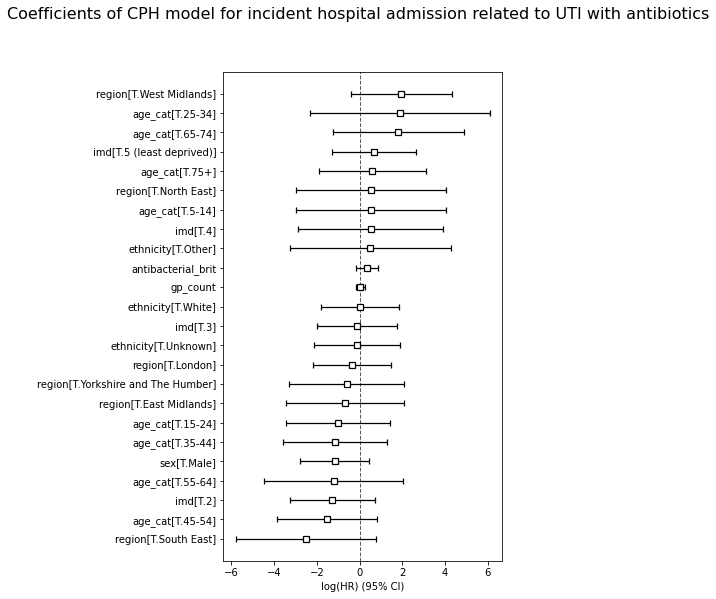

In [62]:
fig, ax = plt.subplots(figsize=(5, 9)
                        )
cph_uti_abs_incdt.plot()
plt.suptitle('Coefficients of CPH model for incident hospital admission related to UTI with antibiotics', fontsize=16)
#_ = ax.set_yticklabels(['Age', 'BMI', 'GP consultations', 'CCI', 'IMD', 'Flu vaccine', 'Antibacterial prescriptions'], 
#                        rotation=45, fontsize=12, ha='right')
#plt.savefig('output/repeat_ABs_outputs/coefficients_cph_uti_abs_incdt.jpg', bbox_inches='tight')
plt.show()

In [ ]:
##save cph model with pickle package

# current_working_dir = os.getcwd()
# print(current_working_dir)

# with open('output/hospitalisation_prediction/cph_uti_abs_incdt.pickle', 'wb') as f:
#     pickle.dump(cph_uti_abs_incdt, f)

# with open('output/hospitalisation_prediction/cph_uti_abs_incdt.pickle', 'rb') as f:
#     cph_uti_abs_incdt = pickle.load(f)

# cph_uti_abs_incdt.summary

#### 4-1-3- Prevalent hospital admission related to UTI with no antibiotics

In [64]:
data_uti_no_abs_prevl.columns

Index(['age', 'age_cat', 'sex', 'bmi', 'BMI_cat', 'gp_count', 'flu_vaccine',
       'region', 'antibacterial_brit', 'imd', 'ethnicity', 'CCI_cat', 'CCI',
       'hx_hosp', 'died_date', 'gp_cons_uti', 'gp_cons_uti_ab', 'uti_date',
       'incdt_uti_date', 'prevl_uti_date', 'admitted_uti_date',
       'sgss_gp_cov_uti_date', 'delta_uti_admitted', 'delta_admitted_died',
       'event_uti_admitted', 'duration_uti_admitted'],
      dtype='object')

In [65]:
#keep relevant variables
data_uti_no_abs_prevl = data_uti_no_abs_prevl[['age', 'age_cat', 'sex', 'bmi', 'BMI_cat', 'gp_count', 'flu_vaccine',
                                                'region', 'antibacterial_brit', 'imd', 'ethnicity', 'CCI_cat', 'CCI',
                                                'event_uti_admitted', 'duration_uti_admitted']]

In [66]:
# printing number of missing values in each variable 
data_uti_no_abs_prevl.isnull().sum()

age                       0
age_cat                   0
sex                       0
bmi                      81
BMI_cat                  81
gp_count                  9
flu_vaccine               0
region                    0
antibacterial_brit        0
imd                       0
ethnicity                 0
CCI_cat                   0
CCI                       0
event_uti_admitted        0
duration_uti_admitted     0
dtype: int64

In [68]:
#drop ros with missing values
data_uti_no_abs_prevl = data_uti_no_abs_prevl.dropna(axis='rows')
#data_uti_no_abs_prevl = data_uti_no_abs_prevl.drop(columns=['smoking_status'])
data_uti_no_abs_prevl.isnull().sum()

age                      0
age_cat                  0
sex                      0
bmi                      0
BMI_cat                  0
gp_count                 0
flu_vaccine              0
region                   0
antibacterial_brit       0
imd                      0
ethnicity                0
CCI_cat                  0
CCI                      0
event_uti_admitted       0
duration_uti_admitted    0
dtype: int64

In [69]:
data_uti_no_abs_prevl.shape

(1524, 15)

In [72]:
cph_uti_no_abs_prevl = CoxPHFitter(penalizer=0.1)
cph_uti_no_abs_prevl.fit(data_uti_no_abs_prevl, 
        duration_col='duration_uti_admitted',
        event_col='event_uti_admitted',
        formula="age_cat + sex + gp_count + flu_vaccine + region + antibacterial_brit + imd + ethnicity"
        )
cph_uti_no_abs_prevl.print_summary()

<lifelines.CoxPHFitter: fitted with 1524 total observations, 403 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 1524
number of events observed = 1121
   partial log-likelihood = -7062.32
         time fit was run = 2022-02-03 09:44:20 UTC

---
                                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                  
age_cat[T.15-24]                     0.01       1.01       0.10            -0.19             0.22                 0.83                 1.24
age_cat[T.25-34]                    -0.14       0.87       0.11            -0.35             0.07                 0.71                 1.08
age_cat[T.35-44]                     0.11       1.12       0.10            -0.09             0.31                 0.91                 1.37
age_cat[T.45-54]                    -0.02       0.98       0.10            -0.22             0.18                 0.80                 1.20
age_cat[T.5-14]                     -0.18       0.83       0.10            -0.39             0.02                 0.68                 1.02
age_cat[T.55-64]                    -0.11       0.90       0.10            -0.31             0.10                 0.73                 1.10
age_cat[T.65-74]                    -0.13       0.88       0.11            -0.34             0.08                 0.71                 1.08
age_cat[T.75+]                      -0.19       0.82       0.10            -0.39            -0.00                 0.68                 1.00
antibacterial_brit                   0.00       1.00       0.02            -0.04             0.04                 0.96                 1.04
ethnicity[T.Other]                   0.11       1.11       0.12            -0.13             0.35                 0.88                 1.42
ethnicity[T.Unknown]                 0.08       1.09       0.09            -0.10             0.27                 0.90                 1.31
ethnicity[T.White]                   0.00       1.00       0.09            -0.17             0.17                 0.85                 1.19
flu_vaccine[T.Yes]                   0.09       1.09       0.09            -0.09             0.27                 0.91                 1.31
gp_count                             0.00       1.00       0.01            -0.01             0.02                 0.99                 1.02
imd[T.2]                            -0.05       0.95       0.08            -0.21             0.11                 0.81                 1.12
imd[T.3]                            -0.04       0.96       0.09            -0.21             0.13                 0.81                 1.14
imd[T.4]                            -0.03       0.97       0.08            -0.19             0.14                 0.83                 1.15
imd[T.5 (least deprived)]            0.12       1.13       0.08            -0.04             0.29                 0.96                 1.33
imd[T.Unknown]                       0.04       1.04       0.14            -0.24             0.32                 0.79                 1.38
region[T.East Midlands]              0.04       1.04       0.11            -0.17             0.25                 0.84                 1.28
region[T.London]                    -0.00       1.00       0.09            -0.17             0.16                 0.84                 1.18
region[T.North East]                -0.02       0.98       0.11            -0.24             0.19                 0.79                 1.21
region[T.North West]                 0.04       1.04       0.11            -0.18             0.26                 0.83                 1.30
region[T.South East]                -0.06    

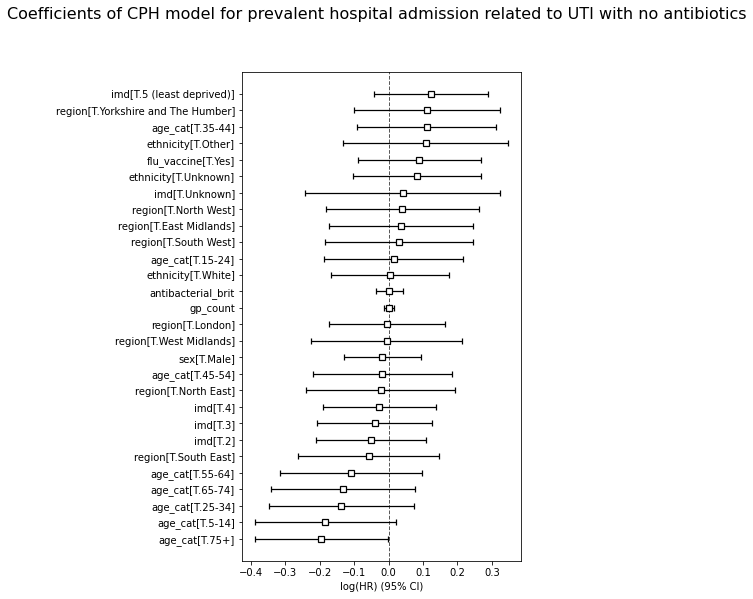

In [73]:
fig, ax = plt.subplots(figsize=(5, 9)
                        )
cph_uti_no_abs_prevl.plot()
plt.suptitle('Coefficients of CPH model for prevalent hospital admission related to UTI with no antibiotics', fontsize=16)
#_ = ax.set_yticklabels(['Age', 'BMI', 'GP consultations', 'CCI', 'IMD', 'Flu vaccine', 'Antibacterial prescriptions'], 
#                        rotation=45, fontsize=12, ha='right')
#plt.savefig('output/repeat_ABs_outputs/coefficients_cph_uti_abs_incdt.jpg', bbox_inches='tight')
plt.show()

In [ ]:
##save cph model with pickle package

# current_working_dir = os.getcwd()
# print(current_working_dir)

# with open('output/hospitalisation_prediction/cph_uti_no_abs_prevl.pickle', 'wb') as f:
#     pickle.dump(cph_uti_no_abs_prevl, f)

# with open('output/hospitalisation_prediction/cph_uti_no_abs_prevl.pickle', 'rb') as f:
#     cph_uti_no_abs_prevl = pickle.load(f)

# cph_uti_no_abs_prevl.summary

#### 4-1-4- Prevalent hospital admission related to UTI with antibiotics

In [63]:
data_uti_abs_prevl.columns

Index(['age', 'age_cat', 'sex', 'bmi', 'BMI_cat', 'gp_count', 'flu_vaccine',
       'region', 'antibacterial_brit', 'imd', 'ethnicity', 'CCI_cat', 'CCI',
       'hx_hosp', 'died_date', 'gp_cons_uti', 'gp_cons_uti_ab', 'uti_date',
       'incdt_uti_date', 'prevl_uti_date', 'admitted_uti_date',
       'sgss_gp_cov_uti_date', 'delta_uti_admitted', 'delta_admitted_died',
       'event_uti_admitted', 'duration_uti_admitted'],
      dtype='object')

In [74]:
#keep relevant variables
data_uti_abs_prevl = data_uti_abs_prevl[['age', 'age_cat', 'sex', 'bmi', 'BMI_cat', 'gp_count', 'flu_vaccine',
                                        'region', 'antibacterial_brit', 'imd', 'ethnicity', 'CCI_cat', 'CCI',
                                        'event_uti_admitted', 'duration_uti_admitted']]

In [75]:
# print number of missing values in each variable 
data_uti_abs_prevl.isnull().sum()

age                      0
age_cat                  0
sex                      0
bmi                      9
BMI_cat                  9
gp_count                 0
flu_vaccine              0
region                   0
antibacterial_brit       0
imd                      0
ethnicity                0
CCI_cat                  0
CCI                      0
event_uti_admitted       0
duration_uti_admitted    0
dtype: int64

In [76]:
#drop ros with missing values
data_uti_abs_prevl = data_uti_abs_prevl.dropna(axis='rows')
#data_uti_abs_prevl = data_uti_abs_prevl.drop(columns=['smoking_status'])
data_uti_abs_prevl.isnull().sum()

age                      0
age_cat                  0
sex                      0
bmi                      0
BMI_cat                  0
gp_count                 0
flu_vaccine              0
region                   0
antibacterial_brit       0
imd                      0
ethnicity                0
CCI_cat                  0
CCI                      0
event_uti_admitted       0
duration_uti_admitted    0
dtype: int64

In [77]:
cph_uti_abs_prevl = CoxPHFitter(penalizer=0.1)
cph_uti_abs_prevl.fit(data_uti_abs_prevl, 
        duration_col='duration_uti_admitted',
        event_col='event_uti_admitted',
        formula="age_cat + sex + gp_count + flu_vaccine + region + antibacterial_brit + imd + ethnicity"
        )
cph_uti_abs_prevl.print_summary()

<lifelines.CoxPHFitter: fitted with 160 total observations, 40 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 160
number of events observed = 120
   partial log-likelihood = -479.81
         time fit was run = 2022-02-03 09:49:54 UTC

---
                                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                  
age_cat[T.15-24]                    -0.88       0.42       0.37            -1.60            -0.15                 0.20                 0.86
age_cat[T.25-34]                    -0.06       0.94       0.34            -0.73             0.61                 0.48                 1.84
age_cat[T.35-44]                     0.35       1.42       0.34            -0.31             1.02                 0.73                 2.77
age_cat[T.45-54]                    -0.31       0.74       0.32            -0.93             0.32                 0.39                 1.38
age_cat[T.5-14]                      0.13       1.14       0.37            -0.60             0.85                 0.55                 2.34
age_cat[T.55-64]                    -0.57       0.57       0.38            -1.32             0.18                 0.27                 1.20
age_cat[T.65-74]                    -0.01       0.99       0.35            -0.70             0.68                 0.50                 1.97
age_cat[T.75+]                      -0.43       0.65       0.34            -1.10             0.23                 0.33                 1.26
antibacterial_brit                  -0.18       0.83       0.07            -0.33            -0.04                 0.72                 0.96
ethnicity[T.Other]                   0.50       1.65       0.42            -0.33             1.34                 0.72                 3.80
ethnicity[T.Unknown]                -0.03       0.97       0.31            -0.64             0.57                 0.53                 1.77
ethnicity[T.White]                  -0.23       0.80       0.29            -0.80             0.34                 0.45                 1.41
flu_vaccine[T.Yes]                  -0.08       0.93       0.39            -0.85             0.70                 0.43                 2.01
gp_count                            -0.00       1.00       0.03            -0.06             0.06                 0.94                 1.06
imd[T.2]                             0.61       1.85       0.27             0.08             1.15                 1.08                 3.16
imd[T.3]                            -0.35       0.71       0.30            -0.93             0.24                 0.39                 1.27
imd[T.4]                             0.12       1.13       0.31            -0.50             0.73                 0.61                 2.08
imd[T.5 (least deprived)]            0.32       1.38       0.27            -0.22             0.86                 0.80                 2.35
imd[T.Unknown]                       0.15       1.16       0.41            -0.64             0.95                 0.52                 2.58
region[T.East Midlands]              0.37       1.45       0.36            -0.34             1.08                 0.71                 2.94
region[T.London]                    -0.46       0.63       0.29            -1.03             0.11                 0.36                 1.12
region[T.North East]                -0.25       0.78       0.35            -0.94             0.45                 0.39                 1.56
region[T.North West]                -0.45       0.63       0.39            -1.22             0.31                 0.30                 1.37
region[T.South East]                -0.24       0.

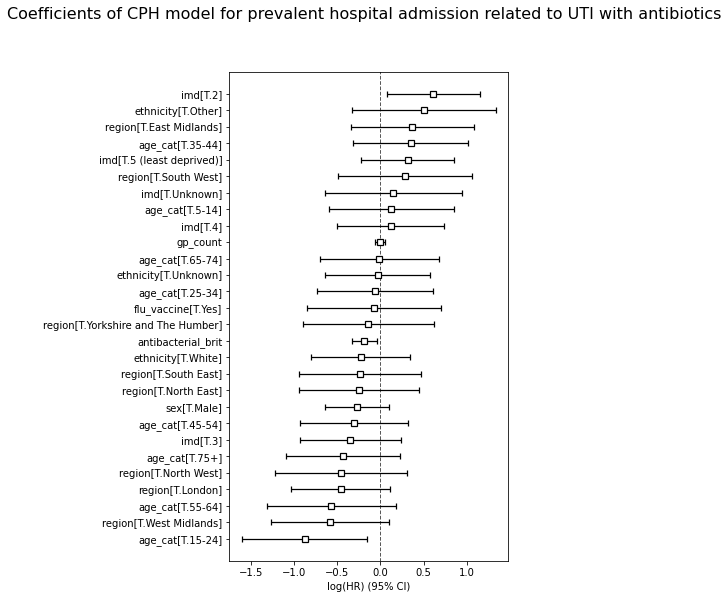

In [78]:
fig, ax = plt.subplots(figsize=(5, 9)
                        )
cph_uti_abs_prevl.plot()
plt.suptitle('Coefficients of CPH model for prevalent hospital admission related to UTI with antibiotics', fontsize=16)
#_ = ax.set_yticklabels(['Age', 'BMI', 'GP consultations', 'CCI', 'IMD', 'Flu vaccine', 'Antibacterial prescriptions'], 
#                        rotation=45, fontsize=12, ha='right')
#plt.savefig('output/repeat_ABs_outputs/coefficients_cph_uti_abs_prevl.jpg', bbox_inches='tight')
plt.show()

In [ ]:
##save cph model with pickle package

# current_working_dir = os.getcwd()
# print(current_working_dir)

# with open('output/hospitalisation_prediction/cph_uti_abs_prevl.pickle', 'wb') as f:
#     pickle.dump(cph_uti_abs_prevl, f)

# with open('output/hospitalisation_prediction/cph_uti_abs_prevl.pickle', 'rb') as f:
#     cph_uti_abs_prevl = pickle.load(f)

# cph_uti_abs_prevl.summary

### 4-2- URTI
#### 4-2-1- Incident hospital admission related to URTI with no antibiotics

In [ ]:
# hosp history, ab type history, 